## Analysis


### Climate Chart: Given a Geohash prefix, create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation). Here’s a (poor quality) script that will generate this for you.

* Earn up to 1 point of extra credit for enhancing/improving this chart (or porting it to a more feature-rich visualization library)

The prefix geohash is 9q94r cutted from 9q94rzdk9 and it is a location in San Francisco.


In [1]:
from datetime import datetime

from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

print(schema)

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

In [2]:
#df = spark.read.format('csv').option('sep', '\t').schema(schema).load('/Volumes/evo/Datasets/NAM_2015_S/*')

dfList = list()
for x in range(1,13):
    if x<10:
        x = '0'+str(x)
    path = "hdfs://orion11:20910/datasets/nam_2015%s.tdv.gz" %x
    df_month = spark.read.format('csv').option('sep', '\t').schema(schema).load(path)
    dfList.append(df_month)

In [3]:
started_at = datetime.now()

# key: month
# value: month_data_list max_temp, min_temp, avg_temp, avg_rain
all_temp_rain_dict = dict()

month_index = 1
for df_month in dfList:
    df_month.createOrReplaceTempView("temp_rain_table")
    max_temp = 0
    min_temp = 0
    avg_temp = 0
    avg_rain = 0
    month_data = list()
    
    temp_rain = spark.sql("select max(temperature_surface) as max_temp,\
    min(temperature_surface) as min_temp,\
    avg(temperature_surface) as avg_temp,\
    avg(precipitable_water_entire_atmosphere) as avg_rain\
    from temp_rain_table").collect()

    for ele in temp_rain:
        month_data.append(ele.max_temp)
        month_data.append(ele.min_temp)
        month_data.append(ele.avg_temp)
        month_data.append(ele.avg_rain)
    
    all_temp_rain_dict[month_index] = month_data
    month_index += 1
    
print(all_temp_rain_dict)
print("Finished. it's been " + str((datetime.now()-started_at).seconds) + " seconds")

{1: [321.3058776855469, 220.9600830078125, 278.4280017600881, 15.4007151189068], 2: [321.85589599609375, 218.9928436279297, 277.6198424566246, 13.73090510602658], 3: [325.72711181640625, 224.5123748779297, 282.37342680636027, 15.254122521463952], 4: [330.8544921875, 231.1042938232422, 285.6748562759392, 16.784410604823112], 5: [328.609619140625, 250.086181640625, 289.69650555733415, 21.304568438239144], 6: [328.758544921875, 263.453857421875, 293.3297806171615, 27.03816524232326], 7: [330.179931640625, 264.17919921875, 295.0883008215764, 30.93388773319382], 8: [331.390625, 265.593505859375, 295.26517995190824, 31.27203283472495], 9: [329.76318359375, 258.19873046875, 293.3856543802662, 28.357654699853768], 10: [326.630859375, 250.59478759765625, 289.5638638867643, 23.53296922862459], 11: [322.370849609375, 232.58804321289062, 285.06030274475773, 18.983783798604218], 12: [321.13922119140625, 226.92987060546875, 282.3588260704892, 16.793512732111274]}
Finished. it's been 2311 seconds


[[  1.         321.30587769 220.96008301 278.42800176  15.40071512]
 [  2.         321.855896   218.99284363 277.61984246  13.73090511]
 [  3.         325.72711182 224.51237488 282.37342681  15.25412252]
 [  4.         330.85449219 231.10429382 285.67485628  16.7844106 ]
 [  5.         328.60961914 250.08618164 289.69650556  21.30456844]
 [  6.         328.75854492 263.45385742 293.32978062  27.03816524]
 [  7.         330.17993164 264.17919922 295.08830082  30.93388773]
 [  8.         331.390625   265.59350586 295.26517995  31.27203283]
 [  9.         329.76318359 258.19873047 293.38565438  28.3576547 ]
 [ 10.         326.63085938 250.5947876  289.56386389  23.53296923]
 [ 11.         322.37084961 232.58804321 285.06030274  18.9837838 ]
 [ 12.         321.13922119 226.92987061 282.35882607  16.79351273]]


/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


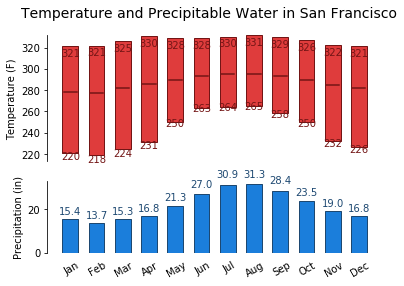

In [40]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

def c2f(t):
    return (t*9/5.0)+32

def k2c(t):
    return t-273.15

def k2f(t):
    return (t*9/5.0)-459.67

def disable_spines(ax):
    for s in ax.spines:
        ax.spines[s].set_visible(False)

rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
use_c = False
converter = k2f
if use_c:
    converter = k2c

first_line = 'Temperature and Precipitable Water in San Francisco'

# convert dict into list list
data = list()
for month in all_temp_rain_dict:
    one_month = list()
    one_month.append(month)
    one_month = one_month + all_temp_rain_dict[month]
    data.append(one_month)

data = np.asarray(data)
print(data)

plt.ion()
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(hspace=.20)
gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

ax0.patch.set_facecolor('None')
ax1.patch.set_facecolor('None')

plt.suptitle(first_line, fontsize=14)

if k2c(data[:, 1]).min() < 5:
    y = 0
    if not use_c:
        y = c2f(0)
    ax0.plot([0, data[:, 1].max() + 1], [y, y], zorder=-1, color='#888888',
            alpha=.75, dashes=(8, 2))

# <month-num>  <high-temp>  <low-temp>  <avg-temp>  <avg-precip>  

rects0 = ax0.bar(.35 + data[:, 0], data[:, 2] - data[:, 1], bottom=data[:, 1],
        width=.6, color='#df3c3c', edgecolor='#731515')

rects1 = ax1.bar(.35 + data[:, 0], data[:, 4], color='#1b7edb', width=.6,
        edgecolor='#1d4871')

##################
plt.xticks(np.arange(0,12) + 1.4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=30)

disable_spines(ax0)
disable_spines(ax1)
ax0.spines['left'].set_visible(True)
ax1.spines['left'].set_visible(True)

for tic in ax0.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax0.yaxis.get_major_ticks():
    tic.tick2On = False

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax1.yaxis.get_major_ticks():
    tic.tick2On = False

for rect in rects1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
        '%.1f' % (height), ha='center', va='bottom', color='#1d4871')

for r, rect in enumerate(rects0):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
        '%d' % int(height + rect.get_y()), ha='center', va='bottom',
        color='#731515')
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - 2,
        '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
    ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
            [data[r, 3], data[r, 3]], color='#731515')

if use_c:
    ax0.set_ylabel('Temperature (C)')
    ax1.set_ylabel('Precipitation (cm)')
else:
    ax0.set_ylabel('Temperature (F)')
    ax1.set_ylabel('Precipitation (in)')

##  Influencers: Determine how features influence each other using Pearson’s correlation coefficient (PCC). The output for this job should include (1) feature pairs sorted by absolute correlation coefficient, and (2) a correlation matrix visualization (heatmaps are a good option).

Here’s an example heatmap generation script.

In [2]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#df = spark.read.format('csv').option('sep', '\t').schema(schema).load('/Volumes/evo/Datasets/NAM_2015_S/*')
df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:20910/datasets/*')
df.take(1)

[Row(Timestamp=1430438400000, Geohash='dndf9tz5r8eb', geopotential_height_lltw=1915.593994140625, water_equiv_of_accum_snow_depth_surface=0.0, drag_coefficient_surface=0.0, sensible_heat_net_flux_surface=-12.571273803710938, categorical_ice_pellets_yes1_no0_surface=0.0, visibility_surface=24220.529296875, number_of_soil_layers_in_root_zone_surface=3.0, categorical_freezing_rain_yes1_no0_surface=0.0, pressure_reduced_to_msl_msl=101235.0, upward_short_wave_rad_flux_surface=4.25, relative_humidity_zerodegc_isotherm=95.0, categorical_snow_yes1_no0_surface=0.0, u-component_of_wind_tropopause=20.28228759765625, surface_wind_gust_surface=3.9325132369995117, total_cloud_cover_entire_atmosphere=98.0, upward_long_wave_rad_flux_surface=371.25927734375, land_cover_land1_sea0_surface=1.0, vegitation_type_as_in_sib_surface=10.0, v-component_of_wind_pblri=-3.47259521484375, albedo_surface=17.25, lightning_surface=0.0, ice_cover_ice1_no_ice0_surface=0.0, convective_inhibition_surface=-12.582763671875,

In [3]:
new_df = df.select([attr for attr in df.columns if attr != 'Geohash' and attr != '' and attr != None])
new_df.show(10)
# print(type(new_df))

+-------------+------------------------+---------------------------------------+------------------------+------------------------------+----------------------------------------+------------------+------------------------------------------+------------------------------------------+---------------------------+----------------------------------+-----------------------------------+---------------------------------+------------------------------+-------------------------+-----------------------------------+---------------------------------+-----------------------------+---------------------------------+-------------------------+--------------+-----------------+------------------------------+-----------------------------+----------------+------------------------------------------------+---------------------+------------------+---------------------------------+-----------------------------------+---------------------------------------+------------------------------+--------------------------

In [26]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=new_df.columns, outputCol=vector_col)
df_vector = assembler.transform(new_df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
big_array = matrix.collect()[0]["pearson({})".format(vector_col)].values


In [27]:
########debug part##########
print(big_array)
print(len(new_df.columns))
new_df_size = new_df.count()
print(new_df_size)
print(type(matrix))
print(matrix.columns)
print(matrix.count())
########debug part##########

[ 1.          0.21099259 -0.14687817 ... -0.27610581  0.1292858
  1.        ]
57
323759744
<class 'pyspark.sql.dataframe.DataFrame'>
['pearson(corr_features)']
1


In [30]:
import numpy as np
new_array_shape = np.array(big_array).reshape(57,57)
print(new_array_shape)

[[ 1.00000000e+00  2.10992595e-01 -1.46878175e-01 ...  1.67444158e-01
  -2.74228419e-02  7.20424733e-10]
 [ 2.10992595e-01  1.00000000e+00 -4.13651883e-01 ...  7.56019969e-01
  -2.84870461e-01 -1.43293926e-01]
 [-1.46878175e-01 -4.13651883e-01  1.00000000e+00 ... -2.48875665e-01
   8.24040954e-02  1.24388344e-01]
 ...
 [ 1.67444158e-01  7.56019969e-01 -2.48875665e-01 ...  1.00000000e+00
  -3.32461824e-01 -2.76105810e-01]
 [-2.74228419e-02 -2.84870461e-01  8.24040954e-02 ... -3.32461824e-01
   1.00000000e+00  1.29285801e-01]
 [ 7.20424733e-10 -1.43293926e-01  1.24388344e-01 ... -2.76105810e-01
   1.29285801e-01  1.00000000e+00]]


/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


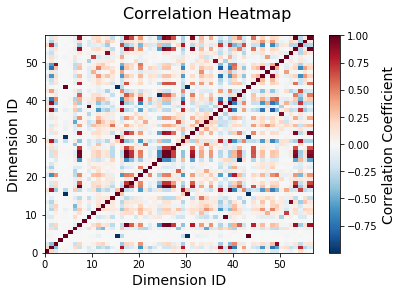

In [32]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

plt.suptitle('Correlation Heatmap', fontsize=16)
plt.xlabel('Dimension ID', fontsize=14)
plt.ylabel('Dimension ID', fontsize=14)

plt.pcolor(new_array_shape, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('Correlation Coefficient', fontsize=14)


In [45]:
for i in range(len(new_df.columns)):
    for j in range(len(new_df.columns)):
        if i != j:
            print(f"{new_df.columns[i]}, {new_df.columns[j]}   {new_array_shape[i][j]}")


Timestamp, geopotential_height_lltw   0.21099259479468063
Timestamp, water_equiv_of_accum_snow_depth_surface   -0.14687817488781568
Timestamp, drag_coefficient_surface   3.0241026489050784e-05
Timestamp, sensible_heat_net_flux_surface   0.042483129599363005
Timestamp, categorical_ice_pellets_yes1_no0_surface   -0.002317680457766982
Timestamp, visibility_surface   0.038813997122541785
Timestamp, number_of_soil_layers_in_root_zone_surface   -3.68211621028698e-11
Timestamp, categorical_freezing_rain_yes1_no0_surface   -0.0011536351693803484
Timestamp, pressure_reduced_to_msl_msl   -0.10619379652020862
Timestamp, upward_short_wave_rad_flux_surface   -0.07865517628037838
Timestamp, relative_humidity_zerodegc_isotherm   -0.026072700436986382
Timestamp, categorical_snow_yes1_no0_surface   -0.025981811936992023
Timestamp, u-component_of_wind_tropopause   -0.0807039705780073
Timestamp, surface_wind_gust_surface   -0.0014715168729024608
Timestamp, total_cloud_cover_entire_atmosphere   -0.0425330

snow_cover_surface, downward_short_wave_rad_flux_surface   -0.11695085781080695
snow_cover_surface, u-component_of_wind_maximum_wind   0.08874201077175721
snow_cover_surface, wilting_point_surface   0.25251110675589955
snow_cover_surface, precipitable_water_entire_atmosphere   -0.464043075161302
snow_cover_surface, u-component_of_wind_pblri   0.1619343299074918
snow_cover_surface, direct_evaporation_cease_soil_moisture_surface   0.25251110675589955
geopotential_height_surface, Timestamp   1.9598954598677377e-10
geopotential_height_surface, geopotential_height_lltw   0.03002086586860365
geopotential_height_surface, water_equiv_of_accum_snow_depth_surface   0.1152365765876208
geopotential_height_surface, drag_coefficient_surface   0.0030217701136297003
geopotential_height_surface, sensible_heat_net_flux_surface   0.0002023997585429188
geopotential_height_surface, categorical_ice_pellets_yes1_no0_surface   0.0015108096552562845
geopotential_height_surface, visibility_surface   -0.05825863